# Capstone Project - The Battle of Neighborhoods - Warsaw
### Applied Data Science Capstone by IBM/Coursera

![Warsaw](https://upload.wikimedia.org/wikipedia/commons/c/c2/Warsaw_panorama.png)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction
---

### Background
Prices of flats in Poland go up faster than inflation, according to the report of money.pl website. Rising apartment prices on the market effectively obscure another problem - the increase in rental prices. This trend affects students, young workers without their own flats or economic immigrants. According to the analysis of experts at Rynekpotny.pl, the increases reached even 23%. Despite everything, life in Warsaw tempts many young people.

### Business Problem
The capital is mainly attracting to itself those who are focused on making dizzying careers or artists and creative people. The heart of the city is the City Centre, which is vibrant with life at any time of day or night. It is one of eighteen districts, but each of them has different advantages. In this scenario, machine learning tools should be used to assist people coming to Warsaw to make wise and effective decisions. As a result, the business problem is: 

   - **How can we help people moving to the capital to choose the right location to rent an flat in Warsaw?**

In order to solve this business problem, we intend to merge Warsaw districts into a cluster in order to recommend facilities. We will recommend facilities according to the amenities and necessary equipment of the surrounding facilities such as: **Café**, **Restaurant**, **Park**.

##  Data <a name="data"></a>
---
To consider the objective stated above, we can list the below data sources used for the analysis.

* **Districts of Warsaw** [Wikipedia](https://en.wikipedia.org/wiki/Districts_of_Warsaw) page was scraped to pull out the necessary information;
* **Coordinate data** for each Districts of Warsaw obtained through Nominatim search engine for OpenStreetMap data;

In order to investigate and target recommended locations in different locations depending on the presence of facilities and necessary objects, we will access the data through the **FourSquare API** and arrange it as a data frame for visualization. By combining data about districts in Warsaw and data about amenities and essential facilities surrounding such properties from the FourSquare API, we will be able to recommend an appropriate location.

## Methodology <a name="methodology"></a>
---
The Methodology section will describe the main elements of the analysis and prediction system. The methodological part consists of four stages:

1. Data Preparation
2. Visualization and Data Exploration
3. Data preparation and Preprocessing 
4. Modeling

### Data Preparation

#### Scrape the Wikipedia page and gathering data into a Pandas dataframe

To start with our analysis, we used the BeautifulSoup package to transform the data in the table on the Wikipedia page into the below pandas dataframe. Subsequently, we transform the data into a pandas dataframe.

In [1]:
import urllib.request, urllib.parse, urllib.error
import pandas as pd

# !conda install -c anaconda beautifulsoup4
from bs4 import BeautifulSoup

In [2]:
url ="https://en.wikipedia.org/wiki/Districts_of_Warsaw"
html = urllib.request.urlopen(url).read()

warsaw_dist_wiki = BeautifulSoup(html, 'html.parser')

In [3]:
warsaw_data = pd.DataFrame({'District' : [''], 'Neighborhood' : ['']})

warsaw_dist_wiki = BeautifulSoup(html, 'html.parser')
wiki_table = warsaw_dist_wiki.findAll('table')

wiki_neighborhood = []
for td in wiki_table[1].find_all('td'):
    wiki_neighborhood.append(td)

warsaw_districts =[]
for th in wiki_table[1].find_all('th'):
    warsaw_districts.append(th.text.strip())
print(f'Warsaw is divided into {len(warsaw_districts)} districts, each one with its own administrative body.')    

print('Each of the districts is customarily subdivided into several neighbourhoods:')
k = 0
for i in range(len(warsaw_districts)):
    k=k-1
    for j in wiki_neighborhood[i].find_all('li'):
        k=k+1
        warsaw_data.loc[i+k] = [warsaw_districts[i], j.text.strip()]
    
    temp_loc = len(wiki_neighborhood[i].find_all('li'))
    print(f'- {warsaw_districts[i]} - {temp_loc} ')

Warsaw is divided into 18 districts, each one with its own administrative body.
Each of the districts is customarily subdivided into several neighbourhoods:
- Bemowo - 10 
- Białołęka - 11 
- Bielany - 14 
- Mokotów - 12 
- Ochota - 4 
- Praga-Południe - 6 
- Praga-Północ - 4 
- Rembertów - 3 
- Śródmieście - 8 
- Targówek - 7 
- Ursus - 5 
- Ursynów - 14 
- Wawer - 12 
- Wesoła - 6 
- Wilanów - 8 
- Włochy - 8 
- Wola - 8 
- Żoliborz - 3 


In [4]:
print('The dataframe has {} districts and {} neighborhoods.'.format(
        len(warsaw_data['District'].unique()),
        warsaw_data.shape[0]
    )
)

warsaw_data.head()

The dataframe has 18 districts and 143 neighborhoods.


,District,Neighborhood
0,Bemowo,Bemowo Lotnisko
1,Bemowo,Boernerowo
2,Bemowo,Chrzanów
3,Bemowo,Fort Bema
4,Bemowo,Fort Radiowo


#### Use geopy library to get the latitude and longitude values of Warsaw Localities

After we have built a dataframe of Warsaw localities along with the district name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. It possible to export data to a csv file for easier loading later.

In [5]:
warsaw_data['Latitude'] = ''
warsaw_data['Longitude'] = ''
warsaw_data.head()

,District,Neighborhood,Latitude,Longitude
0,Bemowo,Bemowo Lotnisko,,
1,Bemowo,Boernerowo,,
2,Bemowo,Chrzanów,,
3,Bemowo,Fort Bema,,
4,Bemowo,Fort Radiowo,,


In [6]:
# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

```python
import time

geolocator = Nominatim(user_agent="to_explorer")

for id in range(len(warsaw_data)):
    address = warsaw_data['Localities'][id] + ', Warsaw, Poland'
    location = geolocator.geocode(address)
    warsaw_data['Latitude'][id] = location.latitude
    warsaw_data['Longitude'][id] = location.longitude
    time.sleep(1)
    
warsaw_data.to_csv('warsaw_localities.csv', index = None, header=True)
```

In [7]:
warsaw_data = pd.read_csv('warsaw_localities.csv', header=0)
warsaw_data.head()

,District,Neighborhood,Latitude,Longitude
0,Bemowo,Bemowo Lotnisko,52.261261,20.910737
1,Bemowo,Boernerowo,52.262390,20.901451
2,Bemowo,Chrzanów,52.216759,20.882969
3,Bemowo,Fort Bema,52.256562,20.938620
4,Bemowo,Fort Radiowo,52.257211,20.891900


#### Utilizing Foursquare API to explore the neighborhoods
Foursquare is the most trusted, independent location data platform for understanding how people move through the real world. We have used, as a part of the assignment, the Foursquare API to retrieve information about the popular spots for each neighborhoods of Warsaw. The recommended location needs to have many eating and shopping venues nearby. Convenient public transport is also required.

Foursquare credentials are defined in hidden cell bellow.

In [8]:
CLIENT_ID = '5D53WUUPEJYZNSE3AF2SZCCPZE1RAW32JLQJE1JNIFJS00VH' # your Foursquare ID
CLIENT_SECRET = '252PIMDDHM2QA4ETIPRACOMCLFZIAWWMMNVT3QGAY3MS3JXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [9]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests

Create a nearby venues function for all the neighborhoods in Warsaw

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

We chose 100 popular places for each neighborhoods within a 10 km radius.

In [11]:
radius = 6000 # define radius
LIMIT  = 200  # limit of number of venues returned by Foursquare API

Create a new dataframe called for the venues of Warsaw

In [12]:
warsaw_venues = getNearbyVenues(names=warsaw_data['Neighborhood'],
                                   latitudes=warsaw_data['Latitude'],
                                   longitudes=warsaw_data['Longitude']
                                  )
print('Import completed')

Import completed


Below is the data frame obtained from the JSON file returned by Foursquare.

In [13]:
print('Total {} of venues are found'.format(len(warsaw_venues)))
warsaw_venues.head()

Total 1427 of venues are found


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bemowo Lotnisko,52.261261,20.910737,Goldwings,52.260579,20.910778,Flight School
1,Bemowo Lotnisko,52.261261,20.910737,Hostel Kingroom,52.264355,20.912432,Hostel
2,Bemowo Lotnisko,52.261261,20.910737,Dach Nacipanej Vistuli,52.259773,20.915648,Airport Service
3,Bemowo Lotnisko,52.261261,20.910737,Garaże,52.258142,20.914198,Beer Garden
4,Bemowo Lotnisko,52.261261,20.910737,Place4Us,52.263905,20.915367,Hotel


### Visualization and Data Exploration

**Generating a map of Warsaw and plotting the Neighborhood data on it**

In [14]:
address = 'Warsaw, Poland'

geolocator = Nominatim(user_agent="to_explorer") # GeocoderTimedOut: Service timed out
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# latitude = 52.2337172
# longitude = 21.07141112883227
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Warsaw, Poland are 52.2337172, 21.07141112883227.


In [15]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

In [16]:
map_warsaw = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district in zip(warsaw_data['Latitude'], warsaw_data['Longitude'], warsaw_data['Neighborhood']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_warsaw)  
    
map_warsaw

#### Numbers of venues for each neighborhood

In [17]:
map_warsaw = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district in zip(warsaw_venues['Venue Latitude'], warsaw_venues['Venue Longitude'], warsaw_venues['Venue Category']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_warsaw)  
    
map_warsaw

In [18]:
warsaw_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Anin,13,13,13,13,13,13
Bemowo Lotnisko,5,5,5,5,5,5
Białołęka Dworska,1,1,1,1,1,1
Boernerowo,4,4,4,4,4,4
Bródno,9,9,9,9,9,9


#### Numbers of unique categories can be curated from all the returned venues

In [19]:
print('There are {} uniques categories.'.format(len(warsaw_venues['Venue Category'].unique())))

There are 234 uniques categories.


Examples of Neighborhood meeting the Venue Category: **Café**

In [20]:
warsaw_venues[warsaw_venues['Venue Category']=='Café'].head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
16,Fort Bema,52.256562,20.938620,Cafe Jurta Forty Bema,52.257985,20.935512,Café
25,Górce,52.245431,20.913714,CieKawa,52.242059,20.913374,Café
63,Kobiałka,52.354573,21.043018,Cafe Karolinka,52.355282,21.038461,Café
80,Tarchomin,52.318028,20.954304,Carmelia,52.321284,20.955756,Café
138,Słodowiec,52.276825,20.960235,COSTA Stare Bielany,52.275127,20.961906,Café


### Data preparation and Preprocessing

#### The number of objects found in the category discussed in the business problem

In [21]:
# selected_category = ['Café', 'Park', 'Pizza Place', 'Restaurant']
selected_category = ['Café', 'Restaurant', 'Park']

Numbers of place in selected categories

In [22]:
for cat in selected_category:
    print(cat, warsaw_venues[warsaw_venues['Venue Category'].str.contains(cat)].shape[0])

Café 86
Restaurant 334
Park 51


#### Select only districts with interesting objects

In [23]:
selected_category = warsaw_venues[warsaw_venues['Venue Category'].isin(selected_category)]

In [24]:
selected_category.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
15,Fort Bema,52.256562,20.938620,Fort Bema,52.256450,20.936549,Park
16,Fort Bema,52.256562,20.938620,Cafe Jurta Forty Bema,52.257985,20.935512,Café
25,Górce,52.245431,20.913714,CieKawa,52.242059,20.913374,Café
35,Groty,52.250801,20.873235,Krasnodwór,52.253985,20.873138,Restaurant
37,Groty,52.250801,20.873235,Lasy Miejskie Warszawy,52.253175,20.867496,Park


In [25]:
warsaw_onehot = pd.get_dummies(selected_category[['Venue Category']], prefix="", prefix_sep="")
warsaw_onehot['Neighborhood'] = selected_category['Neighborhood']

fixed_columns = [warsaw_onehot.columns[-1]] + list(warsaw_onehot.columns[:-1])
warsaw_onehot = warsaw_onehot[fixed_columns]

warsaw_onehot.head()

,Neighborhood,Café,Park,Restaurant
15,Fort Bema,0,1,0
16,Fort Bema,1,0,0
25,Górce,1,0,0
35,Groty,0,0,1
37,Groty,0,1,0


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
warsaw_grouped = warsaw_onehot.groupby('Neighborhood').mean().reset_index()
warsaw_grouped.head()

,Neighborhood,Café,Park,Restaurant
0,Anin,0.5,0.5,0.0
1,Bródno,0.0,1.0,0.0
2,Bródno Podgrodzie,1.0,0.0,0.0
3,Błonia Wilanowskie,0.0,1.0,0.0
4,Czerniaków,1.0,0.0,0.0


In [28]:
warsaw_grouped = warsaw_grouped[warsaw_grouped.loc[:]!=0].dropna()
warsaw_grouped

,Neighborhood,Café,Park,Restaurant
8,Grochów,0.600000,0.200000,0.200000
25,Natolin,0.200000,0.400000,0.400000
31,Powiśle,0.600000,0.200000,0.200000
42,Stara Praga,0.250000,0.250000,0.500000
46,Stary Mokotów,0.600000,0.200000,0.200000
47,Stary Żoliborz,0.500000,0.250000,0.250000
62,Śródmieście Południowe,0.750000,0.083333,0.166667
63,Śródmieście Północne,0.444444,0.222222,0.333333


In [29]:
num_top_venues = 5

for hood in warsaw_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = warsaw_grouped[warsaw_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

----Grochów----
----Natolin----
----Powiśle----
----Stara Praga----
----Stary Mokotów----
----Stary Żoliborz----
----Śródmieście Południowe----
----Śródmieście Północne----


In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
import numpy as np

In [32]:
num_top_venues = 2

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = warsaw_grouped['Neighborhood']

for ind in np.arange(warsaw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(warsaw_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue
8,Grochów,Café,Restaurant
25,Natolin,Restaurant,Park
31,Powiśle,Café,Restaurant
42,Stara Praga,Restaurant,Park
46,Stary Mokotów,Café,Restaurant
47,Stary Żoliborz,Café,Restaurant
62,Śródmieście Południowe,Café,Restaurant
63,Śródmieście Północne,Café,Restaurant


In [33]:
selected_neighborhood = warsaw_grouped['Neighborhood'].values
target_warsaw_venues = warsaw_venues[warsaw_venues['Neighborhood'].isin(selected_neighborhood)]
target_warsaw_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Grochów,24,24,24,24,24,24
Natolin,27,27,27,27,27,27
Powiśle,46,46,46,46,46,46
Stara Praga,35,35,35,35,35,35
Stary Mokotów,29,29,29,29,29,29
Stary Żoliborz,24,24,24,24,24,24
Śródmieście Południowe,100,100,100,100,100,100
Śródmieście Północne,88,88,88,88,88,88


In [34]:
warsaw_onehot = pd.get_dummies(target_warsaw_venues[['Venue Category']], prefix="", prefix_sep="")
warsaw_onehot['Neighborhood'] = target_warsaw_venues['Neighborhood'] 

fixed_columns = [warsaw_onehot.columns[-1]] + list(warsaw_onehot.columns[:-1])
warsaw_onehot = warsaw_onehot[fixed_columns]

warsaw_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Beach Bar,Beer Bar,...,Tiki Bar,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
235,Stary Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,Stary Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237,Stary Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238,Stary Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239,Stary Mokotów,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
warsaw_grouped = warsaw_onehot.groupby('Neighborhood').mean().reset_index()
warsaw_grouped

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Beach Bar,Beer Bar,...,Tiki Bar,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Grochów,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
1,Natolin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,...,0.00,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.00,0.00,0.000000
2,Powiśle,0.000000,0.000000,0.000000,0.043478,0.021739,0.000000,0.043478,0.021739,0.000000,...,0.00,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.00,0.00,0.000000
3,Stara Praga,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,...,0.00,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.028571
4,Stary Mokotów,0.000000,0.000000,0.000000,0.000000,0.103448,0.000000,0.034483,0.000000,0.000000,...,0.00,0.000000,0.034483,0.000000,0.034483,0.000000,0.000000,0.00,0.00,0.000000
5,Stary Żoliborz,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.00,0.00,0.000000
6,Śródmieście Południowe,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.020000,0.000000,0.000000,...,0.01,0.000000,0.080000,0.000000,0.010000,0.000000,0.020000,0.01,0.01,0.000000
7,Śródmieście Północne,0.011364,0.011364,0.011364,0.011364,0.011364,0.011364,0.011364,0.000000,0.034091,...,0.00,0.011364,0.022727,0.000000,0.000000,0.011364,0.011364,0.00,0.00,0.000000


In [36]:
num_top_venues = 10

for hood in warsaw_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = warsaw_grouped[warsaw_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

----Grochów----
----Natolin----
----Powiśle----
----Stara Praga----
----Stary Mokotów----
----Stary Żoliborz----
----Śródmieście Południowe----
----Śródmieście Północne----


In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = warsaw_grouped['Neighborhood']

for ind in np.arange(warsaw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(warsaw_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Grochów,Café,Dessert Shop,Bus Station,Supermarket,Pizza Place,Fast Food Restaurant,Flea Market,Restaurant,Coffee Shop,Mexican Restaurant
1,Natolin,Sushi Restaurant,Restaurant,Park,Coffee Shop,Indian Restaurant,Italian Restaurant,Sandwich Place,Café,Convenience Store,General Entertainment
2,Powiśle,Pizza Place,Café,Eastern European Restaurant,Asian Restaurant,Pub,Polish Restaurant,Bar,Italian Restaurant,Science Museum,Restaurant
3,Stara Praga,Diner,Restaurant,Hotel,Coffee Shop,Middle Eastern Restaurant,Road,Public Art,Plaza,Park,Movie Theater
4,Stary Mokotów,Bakery,Café,Ice Cream Shop,Italian Restaurant,Convenience Store,Coffee Shop,Dessert Shop,Pizza Place,Movie Theater,Eastern European Restaurant
5,Stary Żoliborz,Café,Thai Restaurant,Polish Restaurant,Coffee Shop,Plaza,Burger Joint,Restaurant,Public Art,Playground,Breakfast Spot
6,Śródmieście Południowe,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Cocktail Bar,Italian Restaurant,Sushi Restaurant,Hostel,Bistro,Plaza,Hotel
7,Śródmieście Północne,Nightclub,Coffee Shop,Cocktail Bar,Café,Hotel,Italian Restaurant,Restaurant,Beer Bar,Polish Restaurant,Greek Restaurant


In [38]:
from sklearn.cluster import KMeans

In [39]:
kclusters = 4

warsaw_grouped_clustering = warsaw_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(warsaw_grouped_clustering)
kmeans.labels_[0:10] 

array([3, 2, 1, 1, 0, 1, 1, 1])

In [40]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

warsaw_merged = warsaw_data[warsaw_data['Neighborhood'].isin([hood for hood in warsaw_grouped['Neighborhood']])]
warsaw_merged = warsaw_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

warsaw_merged # check the last columns!

,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Mokotów,Stary Mokotów,52.205272,21.011551,0,Bakery,Café,Ice Cream Shop,Italian Restaurant,Convenience Store,Coffee Shop,Dessert Shop,Pizza Place,Movie Theater,Eastern European Restaurant
53,Praga-Południe,Grochów,52.246707,21.084637,3,Café,Dessert Shop,Bus Station,Supermarket,Pizza Place,Fast Food Restaurant,Flea Market,Restaurant,Coffee Shop,Mexican Restaurant
59,Praga-Północ,Stara Praga,52.250981,21.033605,1,Diner,Restaurant,Hotel,Coffee Shop,Middle Eastern Restaurant,Road,Public Art,Plaza,Park,Movie Theater
66,Śródmieście,Powiśle,52.238055,21.029351,1,Pizza Place,Café,Eastern European Restaurant,Asian Restaurant,Pub,Polish Restaurant,Bar,Italian Restaurant,Science Museum,Restaurant
69,Śródmieście,Śródmieście Północne,52.236806,21.009433,1,Nightclub,Coffee Shop,Cocktail Bar,Café,Hotel,Italian Restaurant,Restaurant,Beer Bar,Polish Restaurant,Greek Restaurant
70,Śródmieście,Śródmieście Południowe,52.222253,21.015700,1,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Cocktail Bar,Italian Restaurant,Sushi Restaurant,Hostel,Bistro,Plaza,Hotel
89,Ursynów,Natolin,52.141101,21.056435,2,Sushi Restaurant,Restaurant,Park,Coffee Shop,Indian Restaurant,Italian Restaurant,Sandwich Place,Café,Convenience Store,General Entertainment
141,Żoliborz,Stary Żoliborz,52.266810,20.992990,1,Café,Thai Restaurant,Polish Restaurant,Coffee Shop,Plaza,Burger Joint,Restaurant,Public Art,Playground,Breakfast Spot


## Analysis <a name="analysis"></a>

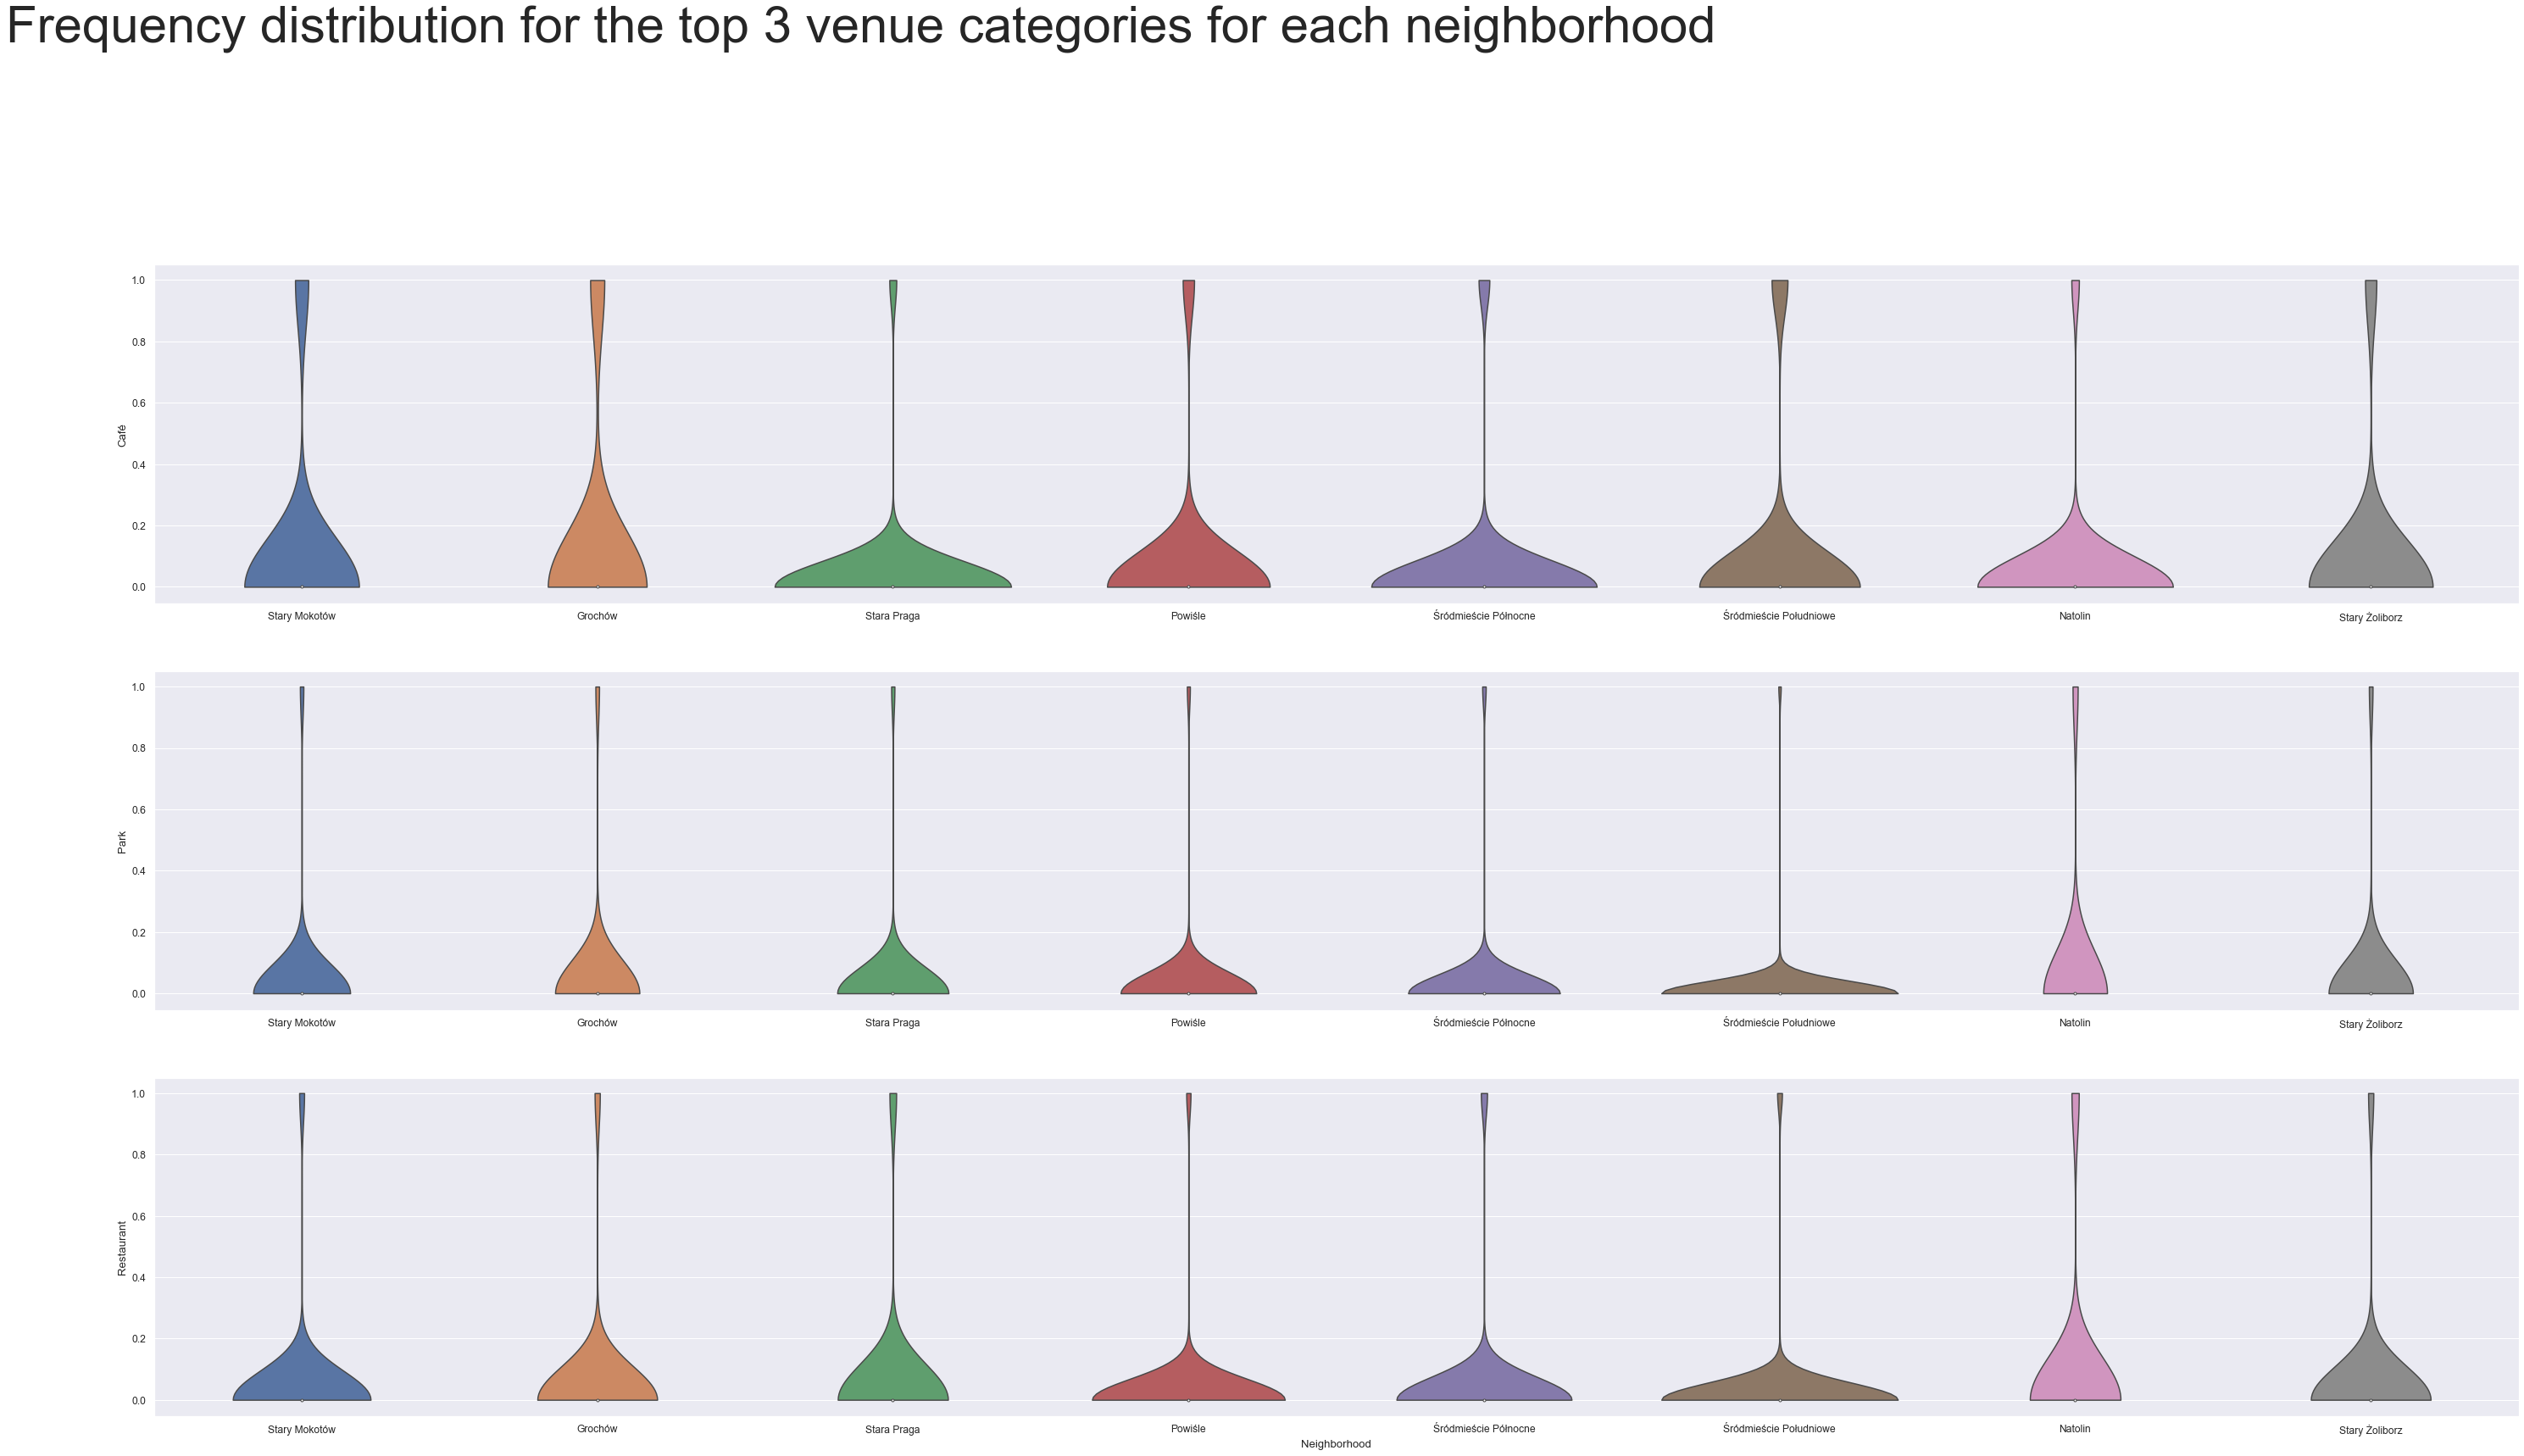

In [41]:
fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)

ax = plt.subplot(3,1,1)
sns.violinplot(x="Neighborhood", y="Café", data=warsaw_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(3,1,2)
sns.violinplot(x="Neighborhood", y="Park", data=warsaw_onehot, cut=0);
plt.xlabel("")

# plt.subplot(4,1,3)
# sns.violinplot(x="Neighborhood", y="Pizza Place", data=warsaw_onehot, cut=0);

plt.subplot(3,1,3)
sns.violinplot(x="Neighborhood", y="Restaurant", data=warsaw_onehot, cut=0);

ax.text(-1.0, 3.1, 'Frequency distribution for the top 3 venue categories for each neighborhood', fontsize=60)
plt.savefig ("Distribution_Frequency_Venues_3_categories_clothing.png", dpi=240)
plt.show()

In [42]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(warsaw_merged['Latitude'], warsaw_merged['Longitude'], warsaw_merged['Neighborhood'], warsaw_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    if np.isnan(cluster):
        cluster = np.nan_to_num(cluster)

    folium.CircleMarker(
        [lat, lon],
        radius=30,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Examine Cluster 0

In [44]:
warsaw_merged.loc[warsaw_merged['Cluster Labels'] == 0, warsaw_merged.columns[[1] + list(range(5, warsaw_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Stary Mokotów,Bakery,Café,Ice Cream Shop,Italian Restaurant,Convenience Store,Coffee Shop,Dessert Shop,Pizza Place,Movie Theater,Eastern European Restaurant


##### Examine Cluster 1

In [45]:
warsaw_merged.loc[warsaw_merged['Cluster Labels'] == 1, warsaw_merged.columns[[1] + list(range(5, warsaw_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,Stara Praga,Diner,Restaurant,Hotel,Coffee Shop,Middle Eastern Restaurant,Road,Public Art,Plaza,Park,Movie Theater
66,Powiśle,Pizza Place,Café,Eastern European Restaurant,Asian Restaurant,Pub,Polish Restaurant,Bar,Italian Restaurant,Science Museum,Restaurant
69,Śródmieście Północne,Nightclub,Coffee Shop,Cocktail Bar,Café,Hotel,Italian Restaurant,Restaurant,Beer Bar,Polish Restaurant,Greek Restaurant
70,Śródmieście Południowe,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Cocktail Bar,Italian Restaurant,Sushi Restaurant,Hostel,Bistro,Plaza,Hotel
141,Stary Żoliborz,Café,Thai Restaurant,Polish Restaurant,Coffee Shop,Plaza,Burger Joint,Restaurant,Public Art,Playground,Breakfast Spot


##### Examine Cluster 2

In [48]:
warsaw_merged.loc[warsaw_merged['Cluster Labels'] == 2, warsaw_merged.columns[[1] + list(range(5, warsaw_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
89,Natolin,Sushi Restaurant,Restaurant,Park,Coffee Shop,Indian Restaurant,Italian Restaurant,Sandwich Place,Café,Convenience Store,General Entertainment


##### Examine Cluster 3

In [49]:
warsaw_merged.loc[warsaw_merged['Cluster Labels'] == 3, warsaw_merged.columns[[1] + list(range(5, warsaw_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Grochów,Café,Dessert Shop,Bus Station,Supermarket,Pizza Place,Fast Food Restaurant,Flea Market,Restaurant,Coffee Shop,Mexican Restaurant


## Results and Discussion <a name="results"></a>
I think it is no surprise that all these districts are very centrally located in the circular layout of Warsaw. Locations meeting the criteria of popular places would usually be in central locations in many cities around the world. From this visualization it is clear that on a practical level, without data on the basis of which decisions could be made, the circle of 103 locations is very large. We have significantly narrowed the search area from 8 potential districts to 5, which should respond to the business problem.

We have drawn conclusions from the data, creating location recommendations, but that's the point. There is no right or wrong answer or conclusion for the task. The task of analyzing the data here is to guide the course of selecting the location of the apartment to narrow the search to only a few main areas that best fit the criteria.

Moreover, FourSquare is not popular in Warsaw, the data maybe out-dated or unreliable, the report should gather more data from other location data source such as Google Place API.

## Conclusion  <a name="conclusion"></a>
Different applications of this analysis are available based on a different methodology and possibly different data sources. The stakeholder problem has been resolved. The stakeholder wants to find the best place to live in Warsaw, and the "best location" factors are based on the number of places in the food, cafe and park category around the location. Machine learning technique based on content filtering is the most appropriate method to solve the problem. Eight destination locations may not be a good choice, but I can quickly choose other locations and issue a recommendation again.